## Train Models

### Set Up

In [100]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV # cross validation
import pickle
import matplotlib.pyplot as plt
# import sage
import shap
import itertools
# from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from matplotlib.colors import LinearSegmentedColormap

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [2]:
# !pip install shap

In [101]:
mft_list_5 = ['care', 'fairness','loyalty','authority','purity']
mft_list = ['care','harm','fairness','cheating','loyalty','betrayal','authority','subversion','purity','degradation']

imbalance_method = ""


### Model Declaration:

In [102]:
class_thresholds = {
    "care": 0.1,
    "harm": 0.45,
    "fairness": 0.25,
    "cheating": 0.35,
    "loyalty": 0.2,
    "betrayal": 0.2,
    "authority": 0.2,
    "subversion": 0.35,
    "purity": 0.2,
    "degradation": 0.2,
    "moral": 0.3
    }

#for the soft values (MoralBert)
def prep_split_dataset_classifier(df, mft, columns_to_drop, is_binary=False):
    """
    Prepare and split the dataset for classification.

    Parameters:
    df (DataFrame): The input dataframe containing the data.
    mft (str): The name of the main feature target column.
    columns_to_drop (list): List of column names to drop from the dataframe.
    is_binary (bool): are the labels binary or do they need thresholding?

    Returns:
    X (DataFrame): The feature set.
    y (DataFrame): The target set.
    X_train (DataFrame): The training set features.
    X_test (DataFrame): The test set features.
    y_train (DataFrame): The training set target.
    y_test (DataFrame): The test set target.
    """

    if not is_binary:
        # Threshold
        df.loc[:, mft] = (df[mft] >= class_thresholds[mft]).astype(int)

    # Create the target set
    y = df[[mft]].copy()

    # Drop specified columns to create the feature set
    X = df.drop(columns_to_drop, axis=1).copy()

    # Split the data into training and testing sets
    # Y stratified so equal distribution of y in training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    return X, y, X_train, X_test, y_train, y_test


def get_best_model_classifier(X_train, y_train):
    """
    Train and select the best classifier model using GridSearchCV.

    Parameters:
    X_train (DataFrame): The training set features.
    y_train (DataFrame): The training set target.

    Returns:
    best_model (XGBClassifier): The best classifier model.
    """

    # Parameter grid for GridSearchCV
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 6],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__reg_lambda': [0.5, 1.0, 1.5],
        'model__reg_alpha': [0.5, 1.0, 1.5]
    }

    # Calculate scale_pos_weight to handle class imbalance
    scale_pos_weight = (y_train.values == 0).sum() / (y_train.values == 1).sum()


    # Create a pipeline that first scales the data, then applies the XGBoost model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(objective='binary:logistic',
                                  seed=42,
                                  subsample=0.9,
                                  eval_metric='auc',
                                  scale_pos_weight=scale_pos_weight,
                                  colsample_bytree=0.5))
    ])

    # Initialize GridSearchCV with 3-fold cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', verbose=1)

    # Fit the model
    grid_search.fit(X_train, y_train)


    f1_mean = grid_search.best_score_
    f1_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    score = {"f1_mean": f1_mean, "f1_std": f1_std}

    # Train the best model with the best parameters
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    return best_model, score

def save_data(filename, data):
    """
    Save the data to a file.

    Parameters:
    filename (str): The name of the file to save the data.
    data: The data to be saved.

    Returns:
    None
    """

    with open(filename, 'wb') as fp:
        pickle.dump(data, fp)
        print('data saved successfully to file.\n')

### Load Dataset

In [103]:
# Load WASABI dataset 10 values
dataset_identifier = "WASABI"
df = pd.read_csv(f"datasets/dataset_WASABI_MFT.csv")
# df = pd.read_csv(f"datasets/m_dataset_en200.csv")
df
# (unthresholded - set is_binary to false in the prep_split_dataset_classifier function when training to apply thresholds)

,file_id,melody.pitch_range,melody.direction,melody.duration_weighted_mean_pitch_height,melody.diff_abs_mean,melody.diff_abs_std,melody.hist_interval_0,melody.hist_interval_1,melody.hist_interval_2,melody.hist_interval_3,...,care,harm,fairness,cheating,loyalty,betrayal,authority,subversion,purity,degradation
0,0,4.122774,0.147059,66.900552,3.661765,3.385133,0.285714,1.000000,0.714286,0.428571,...,0.067451,0.836344,0.592471,0.817725,0.016254,0.089451,0.214116,0.553828,0.044964,0.156521
1,1,4.543938,0.082192,69.445243,4.123288,4.131222,0.230769,1.000000,0.692308,0.615385,...,0.109596,0.420799,0.421735,0.407405,0.016828,0.098190,0.186442,0.379439,0.045733,0.183609
2,2,4.401888,0.087500,70.707742,3.450000,3.153966,0.352941,1.000000,0.411765,0.411765,...,0.041564,0.313886,0.648032,0.730380,0.012910,0.092412,0.267774,0.733943,0.060030,0.442429
3,3,4.549072,0.051724,69.306255,3.758621,3.515043,0.090909,1.000000,0.363636,0.454545,...,0.347138,0.845291,0.555613,0.569022,0.016904,0.193986,0.150853,0.165153,0.045012,0.069184
4,5,2.867308,0.030303,65.310303,2.909091,2.193152,0.200000,0.100000,1.000000,0.200000,...,0.419544,0.135219,0.394128,0.051016,0.062011,0.117457,0.441132,0.226508,0.052027,0.063042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34672,50457,7.096698,0.057692,66.788269,5.730769,5.984324,1.000000,0.833333,0.250000,0.000000,...,0.069938,0.358026,0.654200,0.263386,0.018539,0.120227,0.281626,0.223388,0.053446,0.068994
34673,50471,9.557763,-0.043478,57.475937,5.173913,4.536348,1.000000,0.833333,0.500000,0.166667,...,0.527930,0.267847,0.190032,0.051376,0.030167,0.211580,0.108329,0.098986,0.060720,0.077117
34674,50472,10.947658,-0.303030,66.939610,5.969697,8.454817,0.500000,0.625000,0.000000,0.250000,...,0.393293,0.072010,0.124807,0.028916,0.039224,0.108322,0.229926,0.126123,0.068586,0.153019
34675,50473,3.894942,0.000000,63.362274,3.306452,3.230843,0.142857,0.714286,0.714286,0.214286,...,0.521613,0.181920,0.140915,0.060225,0.025898,0.160219,0.118716,0.133779,0.093819,0.128930


In [30]:
# # # Adapt WASABI to be 5 value model

pairs = [['care','harm'],['fairness','cheating'],['loyalty','betrayal'],['authority','subversion'],['purity','degradation']]

# Iterate over each pair
for pair in pairs:
    col1, col2 = pair

    # Create the new combined column
    df[col1] = ((df[col1] >= class_thresholds[col1]) | (df[col2] >= class_thresholds[col2])).astype(int)

    # Drop the original columns
    df.drop([col2], axis=1, inplace=True)
    print(f"{df[col1].value_counts()}\n")

### Use the code below to load 200 english songs dataset 10 values

In [108]:
dataset_identifier = "en200"
df = pd.read_csv(f"datasets/m_dataset_en200.csv")
df = df.drop(["youtube_id"], axis=1)

In [74]:
# df

In [87]:
# Adapt 200 English songs to be 5 value model

pairs = [['care','harm'],['fairness','cheating'],['loyalty','betrayal'],['authority','subversion'],['purity','degradation']]

# Iterate over each pair
for pair in pairs:
    col1, col2 = pair

    # Create the new combined column
    df[col1] = ((df[col1] == 1) | (df[col2] == 1)).astype(int)

    # Drop the original columns
    df.drop([col2], axis=1, inplace=True)
    print(f"{df[col1].value_counts()}\n")

### Use the code below to load multilingual dataset

In [93]:
# Initialize an empty list to store DataFrames
dfs = []

# List of dataset identifiers
ids = ["en100", "es_100", "fr_100", "gr_100", "ru_100", "tr_100"]

for id in ids:
    path = f"datasets/multilingual_datasets/m_dataset_{id}.csv"
    dfs.append(pd.read_csv(path))

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)

df = df.dropna(subset="care")
df = df.drop(["youtube_id"], axis=1)

for mft in mft_list_5:
    print(f"{df[mft].value_counts()}\n")

In [ ]:
# df

### Data Distribution

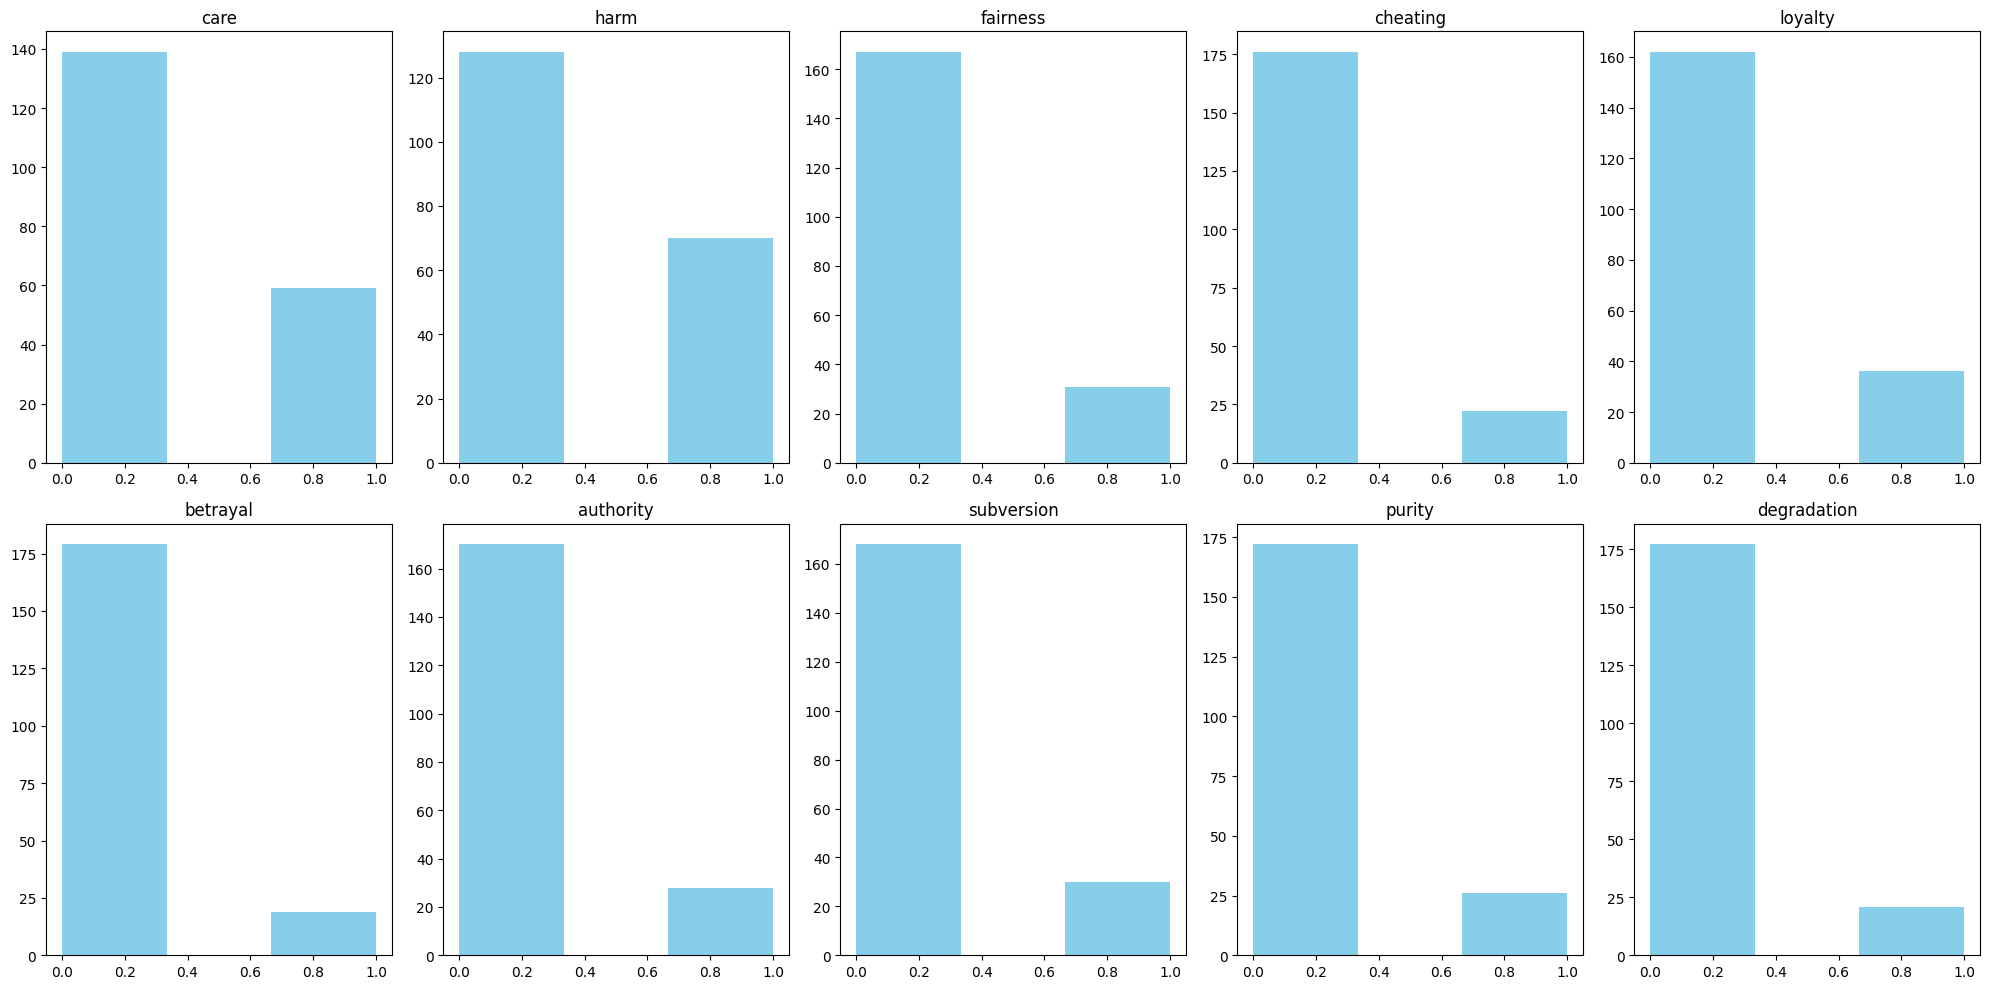

In [ ]:
# Plot histogram of distribution

# Get first 10 columns (mft columns)
selected_columns = ['care', 'harm', 'fairness', 'cheating', 'loyalty', 'betrayal', 'authority', 'subversion', 'purity', 'degradation']
selected_df = df[selected_columns]

# Create a figure and axes
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

# Plot a histogram for each mft
for i, column in enumerate(selected_columns):
    axes[i].hist(selected_df[column].dropna(), bins=3, color='skyblue')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

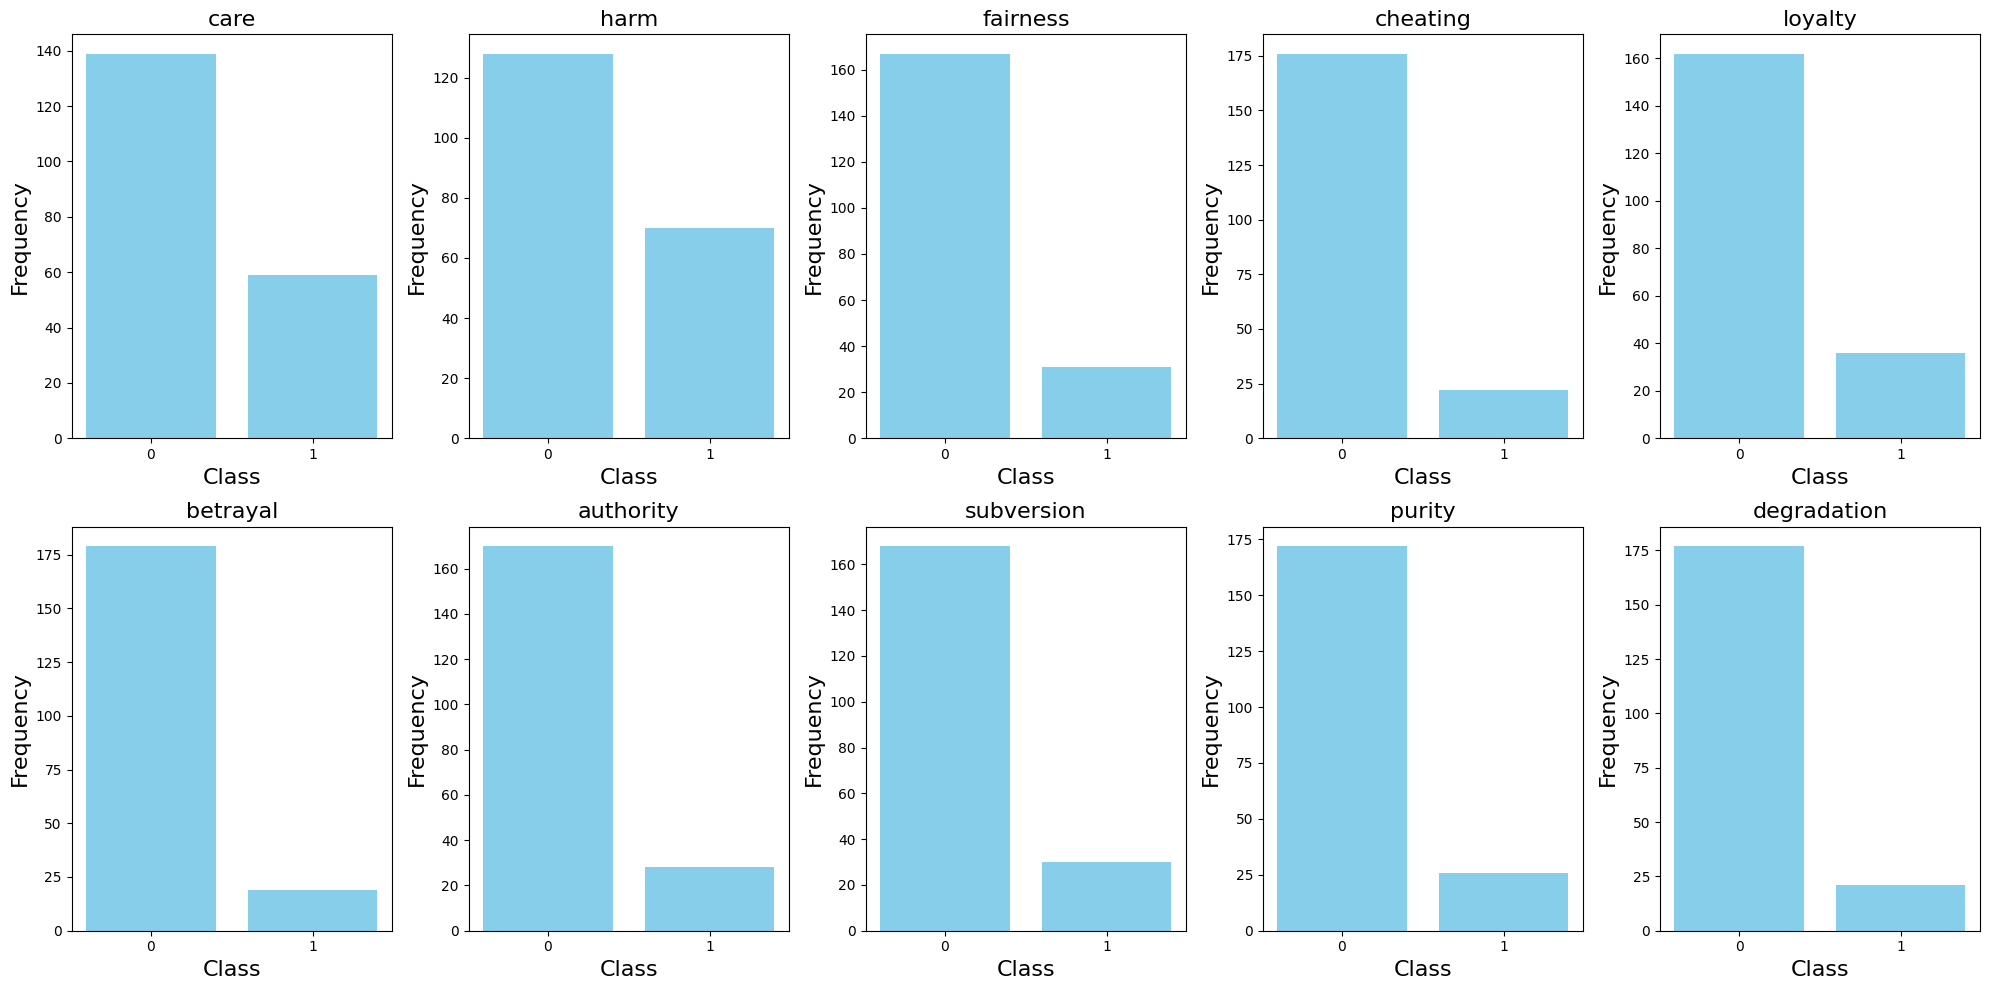

In [ ]:
# Bar plot of distribution

selected_columns = ['care', 'harm', 'fairness', 'cheating', 'loyalty', 'betrayal', 'authority', 'subversion', 'purity', 'degradation']
selected_df = df[selected_columns]

# Create a figure and axes
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

# Plot a bar graph for each mft
for i, column in enumerate(selected_columns):
    value_counts = selected_df[column].value_counts().sort_index()
    axes[i].bar(value_counts.index, value_counts.values, color='skyblue')
    axes[i].set_title(column, fontsize=16)
    axes[i].set_xlabel('Class', fontsize=16)
    axes[i].set_ylabel('Frequency', fontsize=16)
    axes[i].set_xticks([0, 1])

plt.tight_layout()
plt.show()

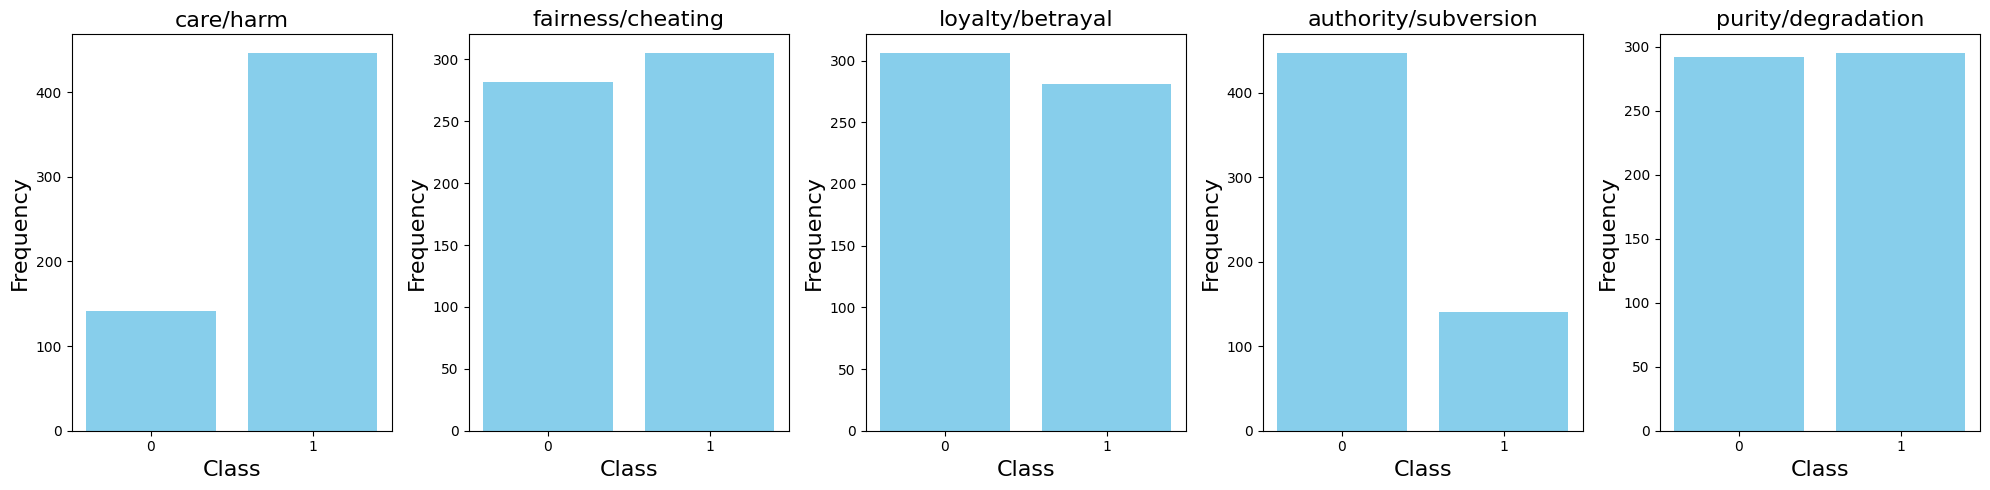

In [ ]:
# Bar plot of distribution
titles = ['care/harm', 'fairness/cheating','loyalty/betrayal','authority/subversion','purity/degradation']
selected_columns = ['care', 'fairness','loyalty','authority','purity']
selected_df = df[selected_columns]

# Create a figure and axes
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.flatten()

# Plot a bar graph for each mft
for i, column in enumerate(selected_columns):
    value_counts = selected_df[column].value_counts().sort_index()
    axes[i].bar(value_counts.index, value_counts.values, color='skyblue')
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel('Class', fontsize=16)
    axes[i].set_ylabel('Frequency', fontsize=16)
    axes[i].set_xticks([0, 1])

plt.tight_layout()
plt.show()

In [16]:
df.shape

(34677, 186)

In [17]:
df

,file_id,melody.pitch_range,melody.direction,melody.duration_weighted_mean_pitch_height,melody.diff_abs_mean,melody.diff_abs_std,melody.hist_interval_0,melody.hist_interval_1,melody.hist_interval_2,melody.hist_interval_3,...,lowlevel.spectral_contrast_valleys.stdev_5,lowlevel.spectral_flux.mean,lowlevel.spectral_flux.stdev,lowlevel.zerocrossingrate.mean,lowlevel.zerocrossingrate.stdev,care,fairness,loyalty,authority,purity
0,0,4.122774,0.147059,66.900552,3.661765,3.385133,0.285714,1.000000,0.714286,0.428571,...,0.703130,0.102052,0.039356,0.068979,0.023729,1,1,0,1,0
1,1,4.543938,0.082192,69.445243,4.123288,4.131222,0.230769,1.000000,0.692308,0.615385,...,0.688001,0.111155,0.034063,0.087028,0.033197,1,1,0,1,0
2,2,4.401888,0.087500,70.707742,3.450000,3.153966,0.352941,1.000000,0.411765,0.411765,...,0.670049,0.109446,0.036305,0.087168,0.031127,0,1,0,1,1
3,3,4.549072,0.051724,69.306255,3.758621,3.515043,0.090909,1.000000,0.363636,0.454545,...,0.896179,0.089567,0.048568,0.101865,0.041289,1,1,0,0,0
4,5,2.867308,0.030303,65.310303,2.909091,2.193152,0.200000,0.100000,1.000000,0.200000,...,0.956347,0.081624,0.054437,0.070533,0.034325,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34672,50457,7.096698,0.057692,66.788269,5.730769,5.984324,1.000000,0.833333,0.250000,0.000000,...,1.357654,0.081145,0.044727,0.087406,0.055548,0,1,0,1,0
34673,50471,9.557763,-0.043478,57.475937,5.173913,4.536348,1.000000,0.833333,0.500000,0.166667,...,1.103668,0.080121,0.056185,0.045196,0.027626,1,0,1,0,0
34674,50472,10.947658,-0.303030,66.939610,5.969697,8.454817,0.500000,0.625000,0.000000,0.250000,...,1.153562,0.078189,0.069368,0.047831,0.041719,1,0,0,1,0
34675,50473,3.894942,0.000000,63.362274,3.306452,3.230843,0.142857,0.714286,0.714286,0.214286,...,1.130563,0.105886,0.079175,0.080008,0.062442,1,0,0,0,0


In [30]:
columns_to_drop = ['file_id', 'care', 'fairness', 'loyalty', 'authority', 'purity','youtube_id']

### Train

In [ ]:
# Train model for each of the MFTs

# If blank the class imbalance is being addressed using weighting in the xgboost classifier
mft_list_5 = ['authority','purity']


if len(df.columns) == 186:
    # 5 value model
    columns_to_drop = mft_list_5 + ["file_id"]
elif len(df.columns)  == 191:
    # 10 value model
    columns_to_drop = mft_list + ["file_id"]
else:
    print("Non Standard column length.")
    raise SystemExit("Stopping execution.")

# so you get a tidy print at the end
end_print = ""

for mft in mft_list_5:
    print(f"Training model {mft}:")
    print("Splitting data...")

    # Use function to prepare the dataset
    # is_binary for hand annotated/5 value models
    X, y, X_train, X_test, y_train, y_test = prep_split_dataset_classifier(df, mft, columns_to_drop, is_binary=True)

    # Optional alternative methods for addressing class imbalance.
    # Uncomment one method at a time

    '''# ROS
    imbalance_method = "_ROS"
    ros = RandomOverSampler(random_state=42)
    # fit predictor and target variable
    X_train, y_train = ros.fit_resample(X_train, y_train)'''

    '''# SMOTE
    imbalance_method = "_SMOTE"
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)'''

    # Perform gridsearch using the above function
    print("Grid search...")
    best_model, best_model_score = get_best_model_classifier(X, y)
    print("Best model found.")

    print(f"F1: {best_model_score}")
    end_print += f"MFT: {mft}, {best_model_score}\n"

    # Save model
    filename = f"wasabi-models-mft-10/best_model_{dataset_identifier}_{mft}{imbalance_method}.pkl"
    save_data(filename, best_model)

print(f"\n{end_print}")

Training model authority:
Splitting data...
Grid search...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/data/home/eey254/.local/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Cer

### Dummy Classifier:

In [125]:
for mft in mft_list:

    X, y, _,_,_,_ = prep_split_dataset_classifier(df, mft, columns_to_drop, is_binary=True)

    majority_classifier = DummyClassifier(strategy='constant', constant = 1)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(majority_classifier, X, y, cv=cv, scoring='f1')

    print(f'MFT: {mft}, Mean:{np.mean(scores):.4f}, Std: {np.std(scores):.4f}')

MFT: care, Mean:0.4590, Std: 0.0101
MFT: harm, Mean:0.5224, Std: 0.0048
MFT: fairness, Mean:0.2706, Std: 0.0139
MFT: cheating, Mean:0.1997, Std: 0.0185
MFT: loyalty, Mean:0.3076, Std: 0.0132
MFT: betrayal, Mean:0.1749, Std: 0.0161
MFT: authority, Mean:0.2474, Std: 0.0165
MFT: subversion, Mean:0.2632, Std: 0.0028
MFT: purity, Mean:0.2320, Std: 0.0146
MFT: degradation, Mean:0.1916, Std: 0.0154


In [112]:
df

,file_id,lowlevel.dynamic_complexity,lowlevel.loudness_ebu128.integrated,melody.pitch_range,melody.direction,melody.duration_weighted_mean_pitch_height,melody.diff_abs_mean,melody.diff_abs_std,melody.hist_interval_0,melody.hist_interval_1,...,care,harm,fairness,cheating,loyalty,betrayal,authority,subversion,purity,degradation
0,t_sRjqjaexs,1.694766,-5.238081,6.915909,0.007194,72.185185,6.071942,5.097101,0.400000,0.800000,...,0,1,0,0,0,1,0,1,0,0
1,Kky-NPNGOd0,5.906698,-17.887123,4.769341,0.013986,54.416669,3.482517,3.307870,0.568182,0.977273,...,0,1,0,1,0,0,0,0,0,0
2,btD-RtHjrrE,4.132512,-10.646622,5.652056,0.052036,63.112099,3.678733,3.620074,0.797297,0.527027,...,1,0,0,1,0,0,0,0,0,0
3,vD7NIP8OcAA,4.082355,-10.622302,4.597576,-0.018904,65.805977,3.368620,3.121703,0.543210,0.925926,...,0,0,0,0,0,0,0,0,1,0
4,q5sQHWfRI60,4.368220,-11.013656,6.382746,0.017045,67.039363,3.592330,3.457945,0.650000,0.900000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,gqZzMmFsNzE,4.920119,-8.144061,6.137887,0.007353,74.631726,5.981618,4.823696,0.918919,0.594595,...,0,0,0,0,0,0,1,0,0,0
194,UMoyT_4mdUU,2.343776,-15.150762,7.179884,0.034247,68.602763,5.107306,4.881228,0.426471,0.705882,...,0,0,0,1,0,1,0,0,0,0
195,0-gOHrzN8tY,5.316685,-11.171266,4.107543,0.006397,64.996914,3.321962,3.207927,0.558824,0.735294,...,0,0,0,1,0,0,0,0,0,0
196,X54gNiZtBJw,5.128541,-8.995208,8.636242,0.007389,66.971109,3.522167,3.509067,0.661765,0.602941,...,1,0,0,0,1,0,0,0,1,0


#### Use the trained model on Wasabi to predict MFT  in human-annotated datasets:

In [119]:
for mft in mft_list:

    # Prepare the dataset
    X, y, _, _, _, _ = prep_split_dataset_classifier(df, mft, columns_to_drop)
    
    # Load the model
    filename = f"wasabi-models-mft-10/best_model_WASABI_{mft}.pkl"
    with open(filename, 'rb') as f:
        model = pickle.load(f)
        
    # Align test dataset features with training dataset
    X = X[model.feature_names_in_]

    # Initialize StratifiedKFold for splitting the data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Predict on the test set (ensure consistent feature order)
        X_test = X_test.reindex(columns=model.feature_names_in_, fill_value=0)
#         print(model.feature_names_in_.shape)
#         print(y_pred.shape)
        y_pred = model.predict(X_test)

        # Calculate F1 score
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

    # Output the mean and standard deviation of the F1 scores
    print(f'MFT: {mft}, Mean F1:{np.mean(f1_scores):.4f}, Std F1: {np.std(f1_scores):.4f}')


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. 

MFT: care, Mean F1:0.4906, Std F1: 0.0377
MFT: harm, Mean F1:0.6233, Std F1: 0.0727
MFT: fairness, Mean F1:0.3008, Std F1: 0.0544
MFT: cheating, Mean F1:0.1107, Std F1: 0.0608
MFT: loyalty, Mean F1:0.3812, Std F1: 0.1111


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. 

MFT: betrayal, Mean F1:0.2061, Std F1: 0.2442
MFT: authority, Mean F1:0.2624, Std F1: 0.0916
MFT: subversion, Mean F1:0.3326, Std F1: 0.1456
MFT: purity, Mean F1:0.1908, Std F1: 0.3104
MFT: degradation, Mean F1:0.3409, Std F1: 0.0749


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Threshold Optimisation

In [120]:
import numpy as np
from sklearn.metrics import f1_score

for mft in mft_list:
    # Prepare the dataset
    X, y, _, _, _, _ = prep_split_dataset_classifier(df, mft, columns_to_drop)
    
    # Load the model
    filename = f"wasabi-models-mft-10/best_model_WASABI_{mft}.pkl"
    with open(filename, 'rb') as f:
        model = pickle.load(f)
        
    # Align test dataset features with training dataset
    X = X[model.feature_names_in_]
    # Initialize StratifiedKFold for splitting the data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    for train_index, test_index in skf.split(X, y):
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Ensure test features match training features
        X_test = X_test.reindex(columns=model.feature_names_in_, fill_value=0)
        
        # Predict probabilities on the test set
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        
        # Determine the optimal threshold
        thresholds = np.linspace(0.01, 0.99, 100)
        
        f1_scores_temp = [f1_score(y_test, y_pred_prob > t) for t in thresholds]
        
        optimal_threshold = thresholds[np.argmax(f1_scores_temp)]
        
        # Apply optimal threshold to predictions
        y_pred = (y_pred_prob >= optimal_threshold).astype(int)
        
        # Calculate F1 score
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)
    # Output the mean and standard deviation of the F1 scores
    print(f'MFT: {mft}, Mean F1:{np.mean(f1_scores):.4f}, Std F1: {np.std(f1_scores):.4f}')


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: care, Mean F1:0.5682, Std F1: 0.0440


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: harm, Mean F1:0.6733, Std F1: 0.0734


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: fairness, Mean F1:0.3830, Std F1: 0.0730


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: cheating, Mean F1:0.2346, Std F1: 0.0379


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: loyalty, Mean F1:0.4747, Std F1: 0.1248


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: betrayal, Mean F1:0.3961, Std F1: 0.1559


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: authority, Mean F1:0.4196, Std F1: 0.1327


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: subversion, Mean F1:0.5026, Std F1: 0.1250


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: purity, Mean F1:0.4160, Std F1: 0.1936


/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/home/eey254/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MFT: degradation, Mean F1:0.4654, Std F1: 0.1614


### Calculate SHAP

In [ ]:
imbalance_method = ""

# For each MFT, calculate shap values
for mft in mft_list_5:

    # Get data
    print("Getting data...")
    X, _, _,_,_,_ = prep_split_dataset_classifier(df, mft, columns_to_drop)
    print("Loading model...")

    # Load the model
    filename = f"foreign_language_models/best_model_{mft}.pkl"
    with open(filename, 'rb') as f:
        model = pickle.load(f)

    print("Getting SHAP...")

    # Float 64 required for SHAP library
    X = X.astype('float64')

    # Compute SHAP values
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    print("Saving SHAP...")
    filename = f'foreign_language_models/shap_{mft}.pkl'
    # save dictionary
    with open(filename, 'wb') as fp:
        pickle.dump(shap_values, fp)
        print('Explanation saved successfully to file\n')

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file



Current MFT: care


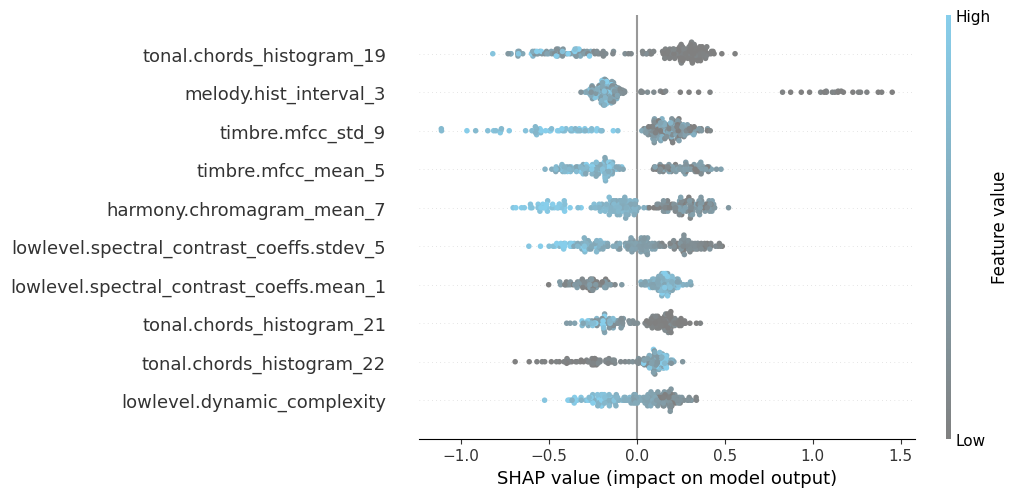

Current MFT: fairness


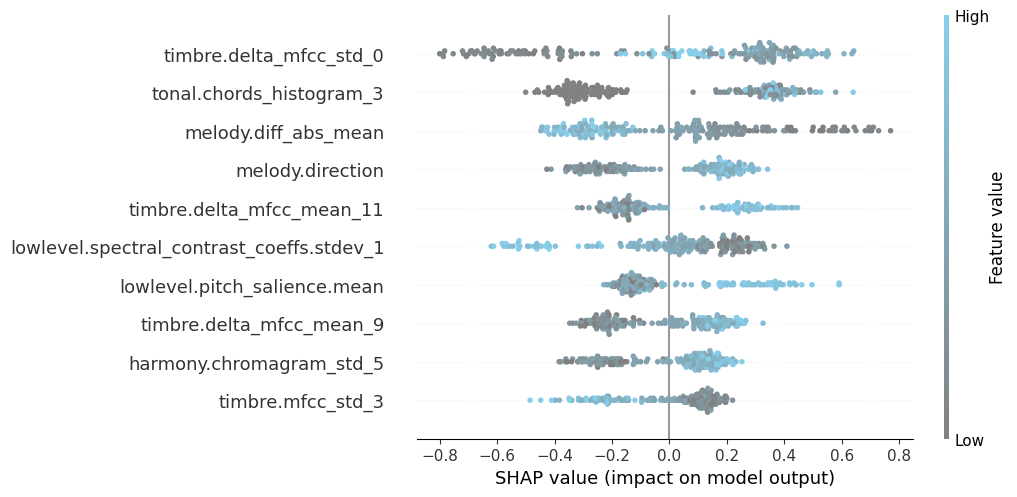

Current MFT: loyalty


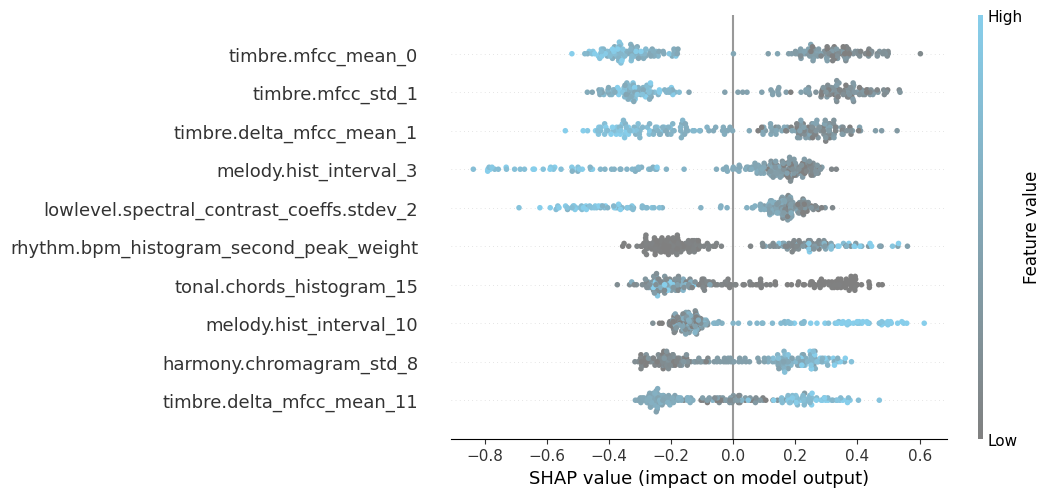

Current MFT: authority


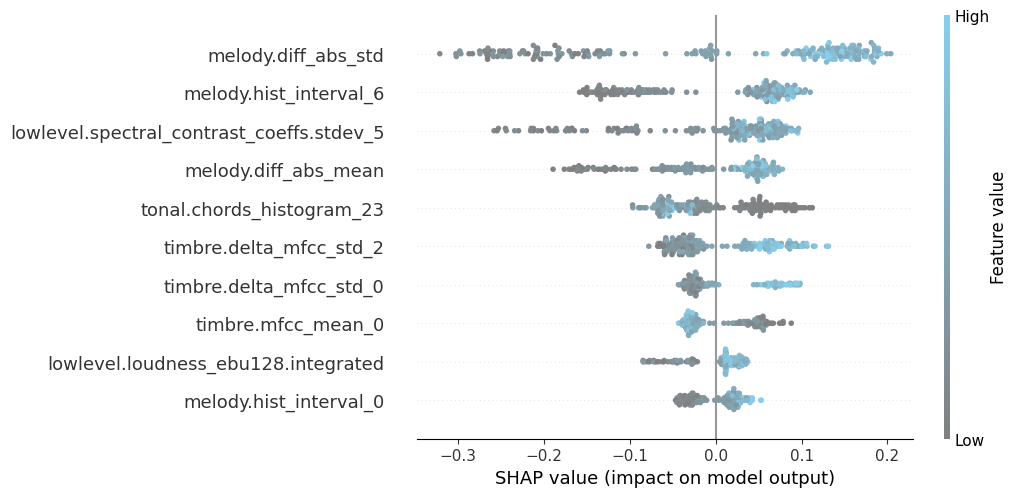

Current MFT: purity


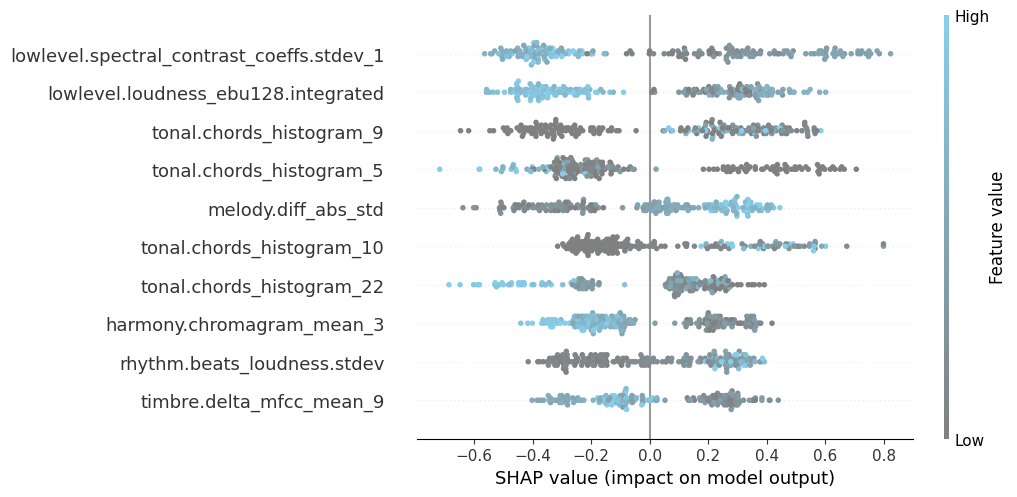

<Figure size 640x480 with 0 Axes>

In [ ]:
# Set up colours for Beeswarm plot
colors = ["grey","skyblue"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot Beeswarm plot of SHAP values
for mft in mft_list_5:
    print(f"Current MFT: {mft}")
    filename = f'foreign_language_models/shap_{mft}.pkl'
    with open(filename, 'rb') as f:
        shap_values = pickle.load(f)
        shap.plots.beeswarm(shap_values, color=cmap)
        plt.show()
        plt.savefig(f'beeswarm_{mft}.png')

# Additional Experiments

### Feature Elimination

In [ ]:
# Cross validated Recurssive Feature Elimination (RFE)

f1_grid_searched = {}

for mft in mft_list:
    print(f"Training model {mft}:")
    selected_features = {}
    f1 = {}

    # Use above function to prepare the dataset
    print("Splitting data...")
    _, _, X_train, X_test, y_train, y_test = prep_split_dataset_classifier(df, mft, columns_to_drop)

    print("Running RFE")

    # Calculate scale_pos_weight
    num_positives = y_train.sum().item()
    num_negatives = len(y_train) - num_positives
    scale_pos_weight = (num_negatives / num_positives)

    # Define the model with the calculated scale_pos_weight
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

    # perform RFE
    rfe = RFECV(estimator=model, cv=StratifiedKFold(5), min_features_to_select=1, step=1, scoring="f1")
    rfe = rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Remove unused features from the dataset
    X_test = X_test.iloc[:, selected_features]
    X_train= X_train.iloc[:, selected_features]

    # Gridsearch on using reduced feature set
    print("Performing Grid Search")
    best_model = get_best_model_classifier(X_train, y_train)

    print("Best model found.")

    # Make predictions from best model
    y_pred = best_model.predict(X_test)

    # Calculate f1 score
    f1 = f1_score(y_test, y_pred)
    f1_grid_searched[mft] = f1
    print(f"Grid Searched F1: {f1}")

    # Save model and feature selection
    filename = f'reduced_feature_models/RFE_{dataset_identifier}_{mft}_best_model.pkl'
    save_data(filename, best_model)

    filename = f'reduced_feature_models/RFE_{dataset_identifier}_{mft}_best_featureset.pkl'
    save_data(filename, selected_features)

print("\nPrint F1s:")
print(f1_grid_searched)

In [ ]:
from supporting_scripts.audiofeatureextractor import DatasetConstructor

feature_categories = {'harmony': ['harmony.chromagram_mean_0', 'harmony.chromagram_mean_1', 'harmony.chromagram_mean_2', 'harmony.chromagram_mean_3', 'harmony.chromagram_mean_4', 'harmony.chromagram_mean_5', 'harmony.chromagram_mean_6', 'harmony.chromagram_mean_7', 'harmony.chromagram_mean_8', 'harmony.chromagram_mean_9', 'harmony.chromagram_mean_10', 'harmony.chromagram_mean_11', 'harmony.chromagram_std_0', 'harmony.chromagram_std_1', 'harmony.chromagram_std_2', 'harmony.chromagram_std_3', 'harmony.chromagram_std_4', 'harmony.chromagram_std_5', 'harmony.chromagram_std_6', 'harmony.chromagram_std_7', 'harmony.chromagram_std_8', 'harmony.chromagram_std_9', 'harmony.chromagram_std_10', 'harmony.chromagram_std_11', 'lowlevel.pitch_salience.mean', 'lowlevel.pitch_salience.stdev', 'tonal.chords_histogram_0', 'tonal.chords_histogram_1', 'tonal.chords_histogram_2', 'tonal.chords_histogram_3', 'tonal.chords_histogram_4', 'tonal.chords_histogram_5', 'tonal.chords_histogram_6', 'tonal.chords_histogram_7', 'tonal.chords_histogram_8', 'tonal.chords_histogram_9', 'tonal.chords_histogram_10', 'tonal.chords_histogram_11', 'tonal.chords_histogram_12', 'tonal.chords_histogram_13', 'tonal.chords_histogram_14', 'tonal.chords_histogram_15', 'tonal.chords_histogram_16', 'tonal.chords_histogram_17', 'tonal.chords_histogram_18', 'tonal.chords_histogram_19', 'tonal.chords_histogram_20', 'tonal.chords_histogram_21', 'tonal.chords_histogram_22', 'tonal.chords_histogram_23', 'tonal.key_krumhansl.key_0', 'tonal.key_krumhansl.key_1', 'tonal.key_krumhansl.key_2', 'tonal.key_krumhansl.key_3', 'tonal.key_krumhansl.key_4', 'tonal.key_krumhansl.key_5', 'tonal.key_krumhansl.key_6', 'tonal.key_krumhansl.key_7', 'tonal.key_krumhansl.key_8', 'tonal.key_krumhansl.key_9', 'tonal.key_krumhansl.key_10', 'tonal.key_krumhansl.key_11', 'tonal.key_krumhansl.scale', 'tonal.key_krumhansl.strength'],
 'dynamics': ['lowlevel.dynamic_complexity', 'lowlevel.loudness_ebu128.integrated'],
 'timbre': ['timbre.mfcc_mean_0', 'timbre.mfcc_mean_1', 'timbre.mfcc_mean_2', 'timbre.mfcc_mean_3', 'timbre.mfcc_mean_4', 'timbre.mfcc_mean_5', 'timbre.mfcc_mean_6', 'timbre.mfcc_mean_7', 'timbre.mfcc_mean_8', 'timbre.mfcc_mean_9', 'timbre.mfcc_mean_10', 'timbre.mfcc_mean_11', 'timbre.mfcc_std_0', 'timbre.mfcc_std_1', 'timbre.mfcc_std_2', 'timbre.mfcc_std_3', 'timbre.mfcc_std_4', 'timbre.mfcc_std_5', 'timbre.mfcc_std_6', 'timbre.mfcc_std_7', 'timbre.mfcc_std_8', 'timbre.mfcc_std_9', 'timbre.mfcc_std_10', 'timbre.mfcc_std_11', 'timbre.delta_mfcc_mean_0', 'timbre.delta_mfcc_mean_1', 'timbre.delta_mfcc_mean_2', 'timbre.delta_mfcc_mean_3', 'timbre.delta_mfcc_mean_4', 'timbre.delta_mfcc_mean_5', 'timbre.delta_mfcc_mean_6', 'timbre.delta_mfcc_mean_7', 'timbre.delta_mfcc_mean_8', 'timbre.delta_mfcc_mean_9', 'timbre.delta_mfcc_mean_10', 'timbre.delta_mfcc_mean_11', 'timbre.delta_mfcc_std_0', 'timbre.delta_mfcc_std_1', 'timbre.delta_mfcc_std_2', 'timbre.delta_mfcc_std_3', 'timbre.delta_mfcc_std_4', 'timbre.delta_mfcc_std_5', 'timbre.delta_mfcc_std_6', 'timbre.delta_mfcc_std_7', 'timbre.delta_mfcc_std_8', 'timbre.delta_mfcc_std_9', 'timbre.delta_mfcc_std_10', 'timbre.delta_mfcc_std_11', 'lowlevel.melbands_flatness_db.mean', 'lowlevel.melbands_flatness_db.stdev', 'lowlevel.melbands_kurtosis.mean', 'lowlevel.melbands_kurtosis.stdev', 'lowlevel.melbands_skewness.mean', 'lowlevel.melbands_skewness.stdev', 'lowlevel.melbands_spread.mean', 'lowlevel.melbands_spread.stdev', 'lowlevel.spectral_centroid.mean', 'lowlevel.spectral_centroid.stdev', 'lowlevel.spectral_complexity.mean', 'lowlevel.spectral_complexity.stdev', 'lowlevel.spectral_contrast_coeffs.mean_0', 'lowlevel.spectral_contrast_coeffs.mean_1', 'lowlevel.spectral_contrast_coeffs.mean_2', 'lowlevel.spectral_contrast_coeffs.mean_3', 'lowlevel.spectral_contrast_coeffs.mean_4', 'lowlevel.spectral_contrast_coeffs.mean_5', 'lowlevel.spectral_contrast_coeffs.stdev_0', 'lowlevel.spectral_contrast_coeffs.stdev_1', 'lowlevel.spectral_contrast_coeffs.stdev_2', 'lowlevel.spectral_contrast_coeffs.stdev_3', 'lowlevel.spectral_contrast_coeffs.stdev_4', 'lowlevel.spectral_contrast_coeffs.stdev_5', 'lowlevel.spectral_contrast_valleys.mean_0', 'lowlevel.spectral_contrast_valleys.mean_1', 'lowlevel.spectral_contrast_valleys.mean_2', 'lowlevel.spectral_contrast_valleys.mean_3', 'lowlevel.spectral_contrast_valleys.mean_4', 'lowlevel.spectral_contrast_valleys.mean_5', 'lowlevel.spectral_contrast_valleys.stdev_0', 'lowlevel.spectral_contrast_valleys.stdev_1', 'lowlevel.spectral_contrast_valleys.stdev_2', 'lowlevel.spectral_contrast_valleys.stdev_3', 'lowlevel.spectral_contrast_valleys.stdev_4', 'lowlevel.spectral_contrast_valleys.stdev_5', 'lowlevel.spectral_flux.mean', 'lowlevel.spectral_flux.stdev', 'lowlevel.zerocrossingrate.mean', 'lowlevel.zerocrossingrate.stdev'],
 'rhythm': ['rhythm.beats_loudness.mean', 'rhythm.beats_loudness.stdev', 'rhythm.bpm', 'rhythm.bpm_histogram_first_peak_bpm', 'rhythm.bpm_histogram_first_peak_weight', 'rhythm.bpm_histogram_second_peak_bpm', 'rhythm.bpm_histogram_second_peak_weight', 'rhythm.danceability', 'rhythm.onset_rate'],
 'melody': ['melody.pitch_range', 'melody.direction', 'melody.duration_weighted_mean_pitch_height', 'melody.diff_abs_mean', 'melody.diff_abs_std', 'melody.hist_interval_0', 'melody.hist_interval_1', 'melody.hist_interval_2', 'melody.hist_interval_3', 'melody.hist_interval_4', 'melody.hist_interval_5', 'melody.hist_interval_6', 'melody.hist_interval_7', 'melody.hist_interval_8', 'melody.hist_interval_9', 'melody.hist_interval_10', 'melody.hist_interval_11'],
 'mft': ['care', 'fairness', 'loyalty', 'authority', 'purity']}

def get_data_by_category(included_categories, df):
    """
    Load the dataset and filter it by the specified categories.

    Parameters:
    included_categories (list): List of categories to include in the filtered dataset.
    full_dataset_path (str): Path to the full dataset file.

    Returns:
    df (DataFrame): The filtered dataset as a pandas DataFrame.
    """
    headers = []

    for cat in included_categories:
        headers += feature_categories[cat]

    df = df[headers]

    return df


def get_unique_combinations(section_list):
    """
    Generate all unique combinations of the sections given.

    Parameters:
    section_list (list): List of sections to generate combinations from.

    Returns:
    list: List of unique combinations, each combination also retains the MFT features.
    """

    # Initialize an empty list to store all combinations
    all_combinations = []

    # Iterate over the range from 1 to the length of the section list
    for i in range(1, len(section_list) + 1):
        # Generate combinations of the current length
        combinations = itertools.combinations(section_list, i)
        # Extend the all_combinations list with the new combinations
        all_combinations.extend(combinations)

    # Convert each combination to a list and append "mft" to it
    return [list(comb) + ["mft"] for comb in all_combinations]

# Get unique combinations based on feature categories
sections = ['timbre','dynamics','rhythm','harmony','melody']
unique_combinations = get_unique_combinations(sections)

print(f"Number of models: {len(unique_combinations)}\n")


Number of models: 31



In [ ]:
import re
with open("/Users/benjaminheyderman/Documents/QM_Final_Project_Research/dataset.pkl", 'rb') as f:
        dataset_dict = pickle.load(f)
vals = dataset_dict["jNLU_A1d_60"]

headers_dict = {}
for section_key, section in vals.items():
    headers_dict[section_key] = list(section.keys())

# List of all columns in the DataFrame
df_columns = df.columns.tolist()

# Function to expand array headers
def expand_headers(headers_dict, df_columns):
    updated_dict = {}
    for category, headers in headers_dict.items():
        updated_dict[category] = []
        for header in headers:
            # Find columns that start with the header and are followed by an index
            matching_columns = [col for col in df_columns if re.match(f'{header}_\d+$', col)]
            if matching_columns:
                updated_dict[category].extend(matching_columns)
            else:
                updated_dict[category].append(header)
    return updated_dict

# Update the dictionary
updated_headers_dict = expand_headers(headers_dict, df_columns)
tally = 0

updated_headers_dict["mft"] = mft_list_5
print(updated_headers_dict)


{'harmony': ['harmony.chromagram_mean_0', 'harmony.chromagram_mean_1', 'harmony.chromagram_mean_2', 'harmony.chromagram_mean_3', 'harmony.chromagram_mean_4', 'harmony.chromagram_mean_5', 'harmony.chromagram_mean_6', 'harmony.chromagram_mean_7', 'harmony.chromagram_mean_8', 'harmony.chromagram_mean_9', 'harmony.chromagram_mean_10', 'harmony.chromagram_mean_11', 'harmony.chromagram_std_0', 'harmony.chromagram_std_1', 'harmony.chromagram_std_2', 'harmony.chromagram_std_3', 'harmony.chromagram_std_4', 'harmony.chromagram_std_5', 'harmony.chromagram_std_6', 'harmony.chromagram_std_7', 'harmony.chromagram_std_8', 'harmony.chromagram_std_9', 'harmony.chromagram_std_10', 'harmony.chromagram_std_11', 'lowlevel.pitch_salience.mean', 'lowlevel.pitch_salience.stdev', 'tonal.chords_histogram_0', 'tonal.chords_histogram_1', 'tonal.chords_histogram_2', 'tonal.chords_histogram_3', 'tonal.chords_histogram_4', 'tonal.chords_histogram_5', 'tonal.chords_histogram_6', 'tonal.chords_histogram_7', 'tonal.cho

In [1]:
# Conduct category elemination feature selection
f1_values_feature_comparison = {}
dataset_identifier = "fulldat"

columns_to_drop = mft_list_5

#create blank nested dictionary for f1 scores
for mft in mft_list_5:
    f1_values_feature_comparison[mft] = {}

# For each combination of the category
for unique_combination in unique_combinations:
    # Get the right columsn of the dataset
    df_by_category = get_data_by_category(unique_combination, df)

    print(f"Current combination: {', '.join(unique_combination[:-1])}")
    print(f'The number of columns in the DataFrame is: {df_by_category.shape[1]}\n')
    # For each mft find the best model
    for mft in mft_list_5:
        print(f"Training model {mft}:")
        print("Splitting data...")
        X, y, _,_,_,_ = prep_split_dataset_classifier_binary(df_by_category, mft, columns_to_drop)

        # Perform gridsearch
        print("Grid search...")
        best_model, best_model_score = get_best_model_classifier(X, y)
        print("Best model found.")

        print(f"{mft}: {best_model_score}")

        f1_values_feature_comparison[mft][', '.join(unique_combination[:-1])] = best_model_score

        # Save data
        filename = f"category_elim_{dataset_identifier}_{mft}_{'_'.join(unique_combination[:-1])}"
        save_data(filename, best_model)

# Convert f1 dictionary to DataFrame
print(f1_values_feature_comparison)

### Bi-polar model

In [ ]:
# Load the datasets
df_bill = pd.read_csv("dataset_billboard_MFT.csv")
df_WASABI = pd.read_csv("dataset_WASABI_MFT.csv")

df_morality = pd.concat([df_bill, df_WASABI], ignore_index=True)

# Categorise moral and immoral MFTs
moral_headers = ['care','fairness','loyalty','authority','purity']
immoral_headers = ['harm','cheating','betrayal','subversion','degradation']

# Add new column for morality
df_morality['moral'] = None

# Check for the conditions and set 'moral' column values
for i, row in df_morality.iterrows():
    moral_condition = (row[moral_headers] > 0.6).any() and (row[immoral_headers] <= 0.2).all()
    immoral_condition = (row[immoral_headers] > 0.6).any() and (row[moral_headers] <= 0.2).all()

    if moral_condition:
        df_morality.at[i, 'moral'] = 1
    elif immoral_condition:
        df_morality.at[i, 'moral'] = 0

# Remove rows that are morally ambiguous
df_morality = df_morality.dropna(subset=['moral'])

# Make sure 'moral' column is of int type
df_morality['moral'] = df_morality['moral'].astype(int)

# Save data
df_morality.to_csv('dataset_with_morality.csv', index=False)
print(df_morality.head())

In [ ]:
imbalance_method = ""

print("Splitting data...")

# Use above function to prepare the dataset
_, _, X_train, X_test, y_train, y_test = prep_split_dataset_classifier(df_morality, "moral", columns_to_drop+["moral"])

# Perform gridsearch using the above function
print("Grid search...")
best_model = get_best_model_classifier(X_train, y_train)
print("Best model found.")

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate f1 to test performance
f1 = f1_score(y_test, y_pred)
print(f"F1: {f1}")

# Save model
filename = f"best_model_combined_data_moral{imbalance_method}.pkl"
save_data(filename, best_model)

## Analysis

### Cross-Dataset validation

In [ ]:
# Billboard/WASABI

import numpy as np

# Initialize the dictionary
f1s = {"billboard": {}, "WASABI": {}}

# Load the datasets
df_bill = pd.read_csv("dataset_billboard_MFT.csv")
df_WASABI = pd.read_csv("dataset_WASABI_MFT.csv")

def calculate_f1_scores(df, dataset_identifier):
    """
    Load model and get f1 score.

    Parameters:
    df (Dataframe): Data
    dataset_identifier (str):  Name of the dataset being analysed

    Returns:
    None
    """
    for mft in mft_list:
        # Get data
        X, y, _, _, _, _ = prep_split_dataset_classifier(df, mft, columns_to_drop)

        # Load model
        filename = f"best_model_{dataset_identifier}_{mft}{imbalance_method}.pkl"
        with open(filename, 'rb') as f:
            model = pickle.load(f)

        y_pred = model.predict(X)
        # Calculate f1 to test performance
        f1 = f1_score(y, y_pred)

        f1s[dataset_identifier][mft] = f1


# Calculate F1 scores for each dataset/model combination
calculate_f1_scores(df_WASABI, "billboard")
calculate_f1_scores(df_bill, "WASABI")

# Create a list of keys (moral values) and indices
keys = list(f1s["WASABI"].keys())
indices = np.arange(len(keys))

# Width of the bars
bar_width = 0.35

# Plot the f1 values for both sets
plt.figure(figsize=(10, 6))

plt.bar(indices, f1s["billboard"].values(), bar_width, color='skyblue', label='Train: Billboard, Test: WASABI')
plt.bar(indices + bar_width, f1s["WASABI"].values(), bar_width, color='grey', label='Train: WASABI, Test: Billboard')

# Add labels, title, and legend
plt.xlabel('Moral Value')
plt.ylabel('F1 Score')
plt.title('Cross-Dataset Validation')
plt.xticks(indices + bar_width / 2, keys, rotation=45)

plt.legend()
plt.show()

In [ ]:
# WASABI/EN200

import numpy as np

# Load the datasets
df_WASABI = pd.read_csv("dataset_WASABI_MFT.csv")

df = df[df_WASABI.columns]

def calculate_f1_scores(df, dataset_identifier):
    """
    Load model and get f1 score.

    Parameters:
    df (Dataframe): Data
    dataset_identifier (str):  Name of the dataset being analysed

    Returns:
    None
    """
    for mft in mft_list:
        # Get data
        X, y, _, _, _, _ = prep_split_dataset_classifier(df, mft, columns_to_drop)

        # Load model
        filename = f"best_model_{dataset_identifier}_{mft}{imbalance_method}.pkl"
        with open(filename, 'rb') as f:
            model = pickle.load(f)

        y_pred = model.predict(X)
        # Calculate f1 to test performance
        f1 = f1_score(y, y_pred)
        print(f"f1 {mft}: {f1}")
        #f1s[dataset_identifier][mft] = f1

calculate_f1_scores(df, "WASABI")

f1 care: 0.5645161290322581
f1 harm: 0.6164383561643836
f1 fairness: 0.29714285714285715
f1 cheating: 0.12
f1 loyalty: 0.2857142857142857
f1 betrayal: 0.2
f1 authority: 0.225
f1 subversion: 0.35714285714285715
f1 purity: 0.15384615384615385
f1 degradation: 0.3291139240506329


### SAGE

In [ ]:
# For each MFT, calculate SAGE values
for mft in ["care", "harm", "cheating", "subversion", "degradation"]:
    # Get data
    print(f"Getting data...")
    X, y, _,_,_,_ = prep_split_dataset_classifier(df, mft, columns_to_drop)
    print("Loading model...")

    # Load model
    filename = f"best_model_{dataset_identifier}_{mft}{imbalance_method}.pkl"
    with open(filename, 'rb') as f:
        model = pickle.load(f)

    print("Getting sage...")
    # Calculate SAGE
    imputer = sage.MarginalImputer(model, X[:128].to_numpy())
    estimator = sage.PermutationEstimator(imputer, "cross entropy")
    sage_values = estimator(X.to_numpy(), y.to_numpy())
    sage_values.plot(X.columns, max_features=10, orientation="horizontal", color="skyblue")
    print("Saving sage...")
    filename = f'sage_{dataset_identifier}_{mft}{imbalance_method}.pkl'
    with open(filename, 'wb') as fp:
        pickle.dump(sage_values, fp)
        print('Explanation saved successfully to file\n')

In [ ]:
# For each MFT, plot sage values
for mft in mft_list:
    print(f"Current MFT: {mft}")
    filename = f'sage_{dataset_identifier}_{mft}{imbalance_method}.pkl'
    with open(filename, 'rb') as f:
        sage_values = pickle.load(f)
    X, y, _,_,_,_ = prep_split_dataset_classifier("subversion", columns_to_drop)
    sage_values.plot(X.columns, max_features=10, orientation="horizontal")

### SHAP

In [ ]:
#Calculate SHAP
imbalance_method = ""

# For each MFT, calculate shap values
for mft in ["care", "harm", "loyalty", "authority", "subversion"]:

    # Get data
    print("Getting data...")
    X, _, _,_,_,_ = prep_split_dataset_classifier(df, mft, columns_to_drop)
    print("Loading model...")

    # Load the model
    filename = f"best_model_{dataset_identifier}_{mft}{imbalance_method}.pkl"
    with open(filename, 'rb') as f:
        model = pickle.load(f)

    print("Getting SHAP...")

    # Float 64 required for SHAP library
    X = X.astype('float64')

    # Compute SHAP values
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    print("Saving SHAP...")
    filename = f'shap_{dataset_identifier}_{mft}{imbalance_method}.pkl'
    # save dictionary
    with open(filename, 'wb') as fp:
        pickle.dump(shap_values, fp)
        print('Explanation saved successfully to file\n')

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file

Getting data...
Loading model...
Getting SHAP...
Saving SHAP...
Explanation saved successfully to file



Current MFT: care


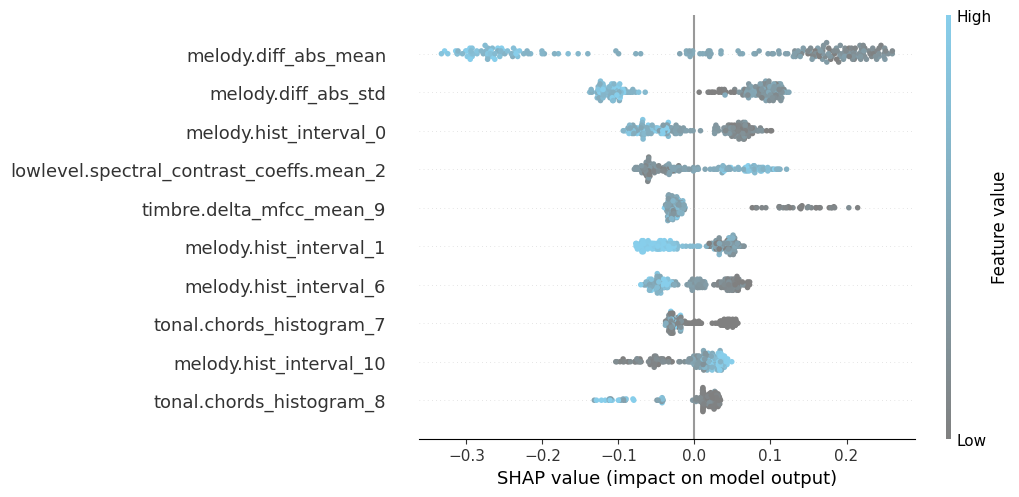

Current MFT: harm


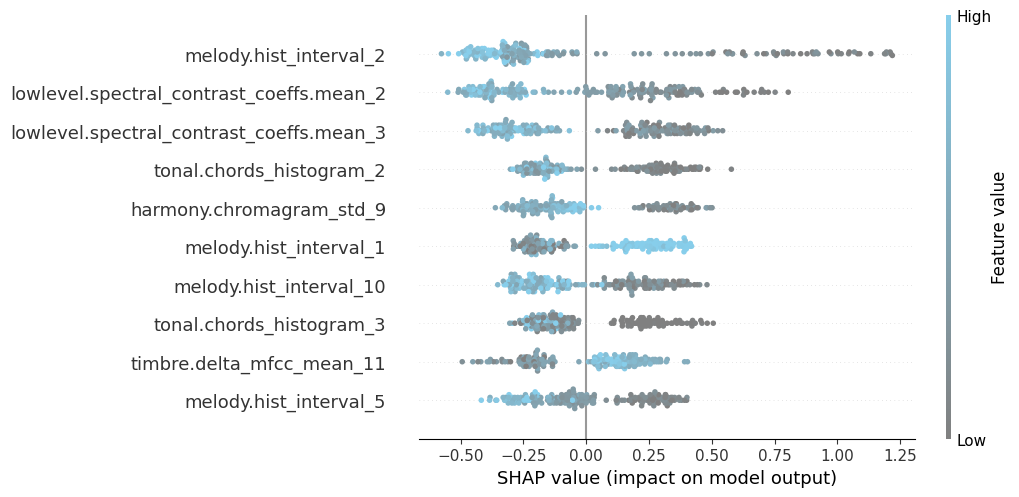

Current MFT: loyalty


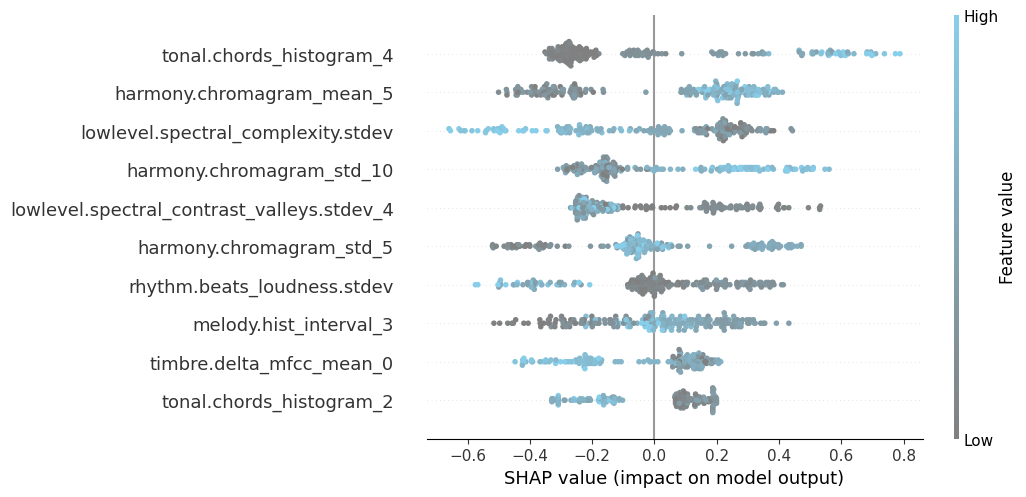

Current MFT: authority


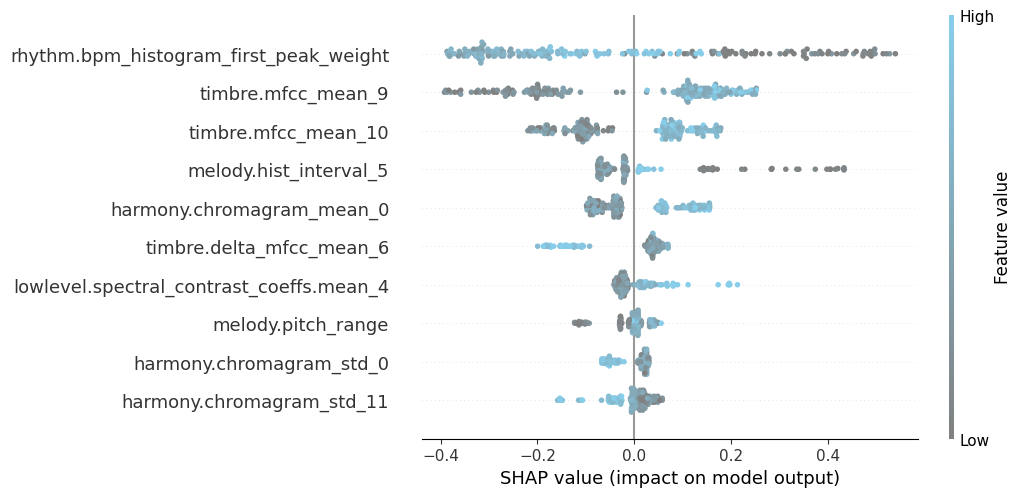

Current MFT: subversion


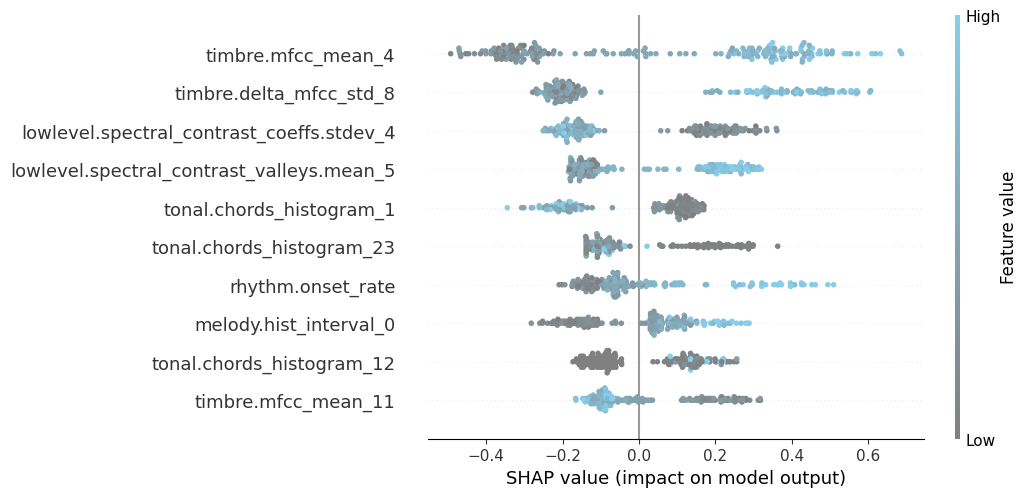

In [ ]:
# Set up colours for Beeswarm plot
colors = ["grey","skyblue"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot Beeswarm plot of SHAP values
for mft in ["care", "harm", "loyalty", "authority", "subversion"]:
    print(f"Current MFT: {mft}")
    filename = f'shap_{dataset_identifier}_{mft}{imbalance_method}.pkl'
    with open(filename, 'rb') as f:
        shap_values = pickle.load(f)
        shap.plots.beeswarm(shap_values, color=cmap)